## Load

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from ast import literal_eval
from tqdm.auto import tqdm
import ray
import os

np.random.seed=42

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/")
print(LOG_PATH)


/Users/rco/github/p_metaheuristic/data/log


In [3]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

In [4]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [5]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}

uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [6]:
uef[uef.port==1].describe()

,mean_return,var_return,port
count,2000.000000,2000.000000,2000.0
mean,0.006825,0.001579,1.0
std,0.002334,0.001116,0.0
min,0.002784,0.000642,1.0
25%,0.004804,0.000716,1.0
50%,0.006825,0.001058,1.0
75%,0.008845,0.002150,1.0
max,0.010865,0.004776,1.0


In [7]:
df_stats[df_stats.port==1].describe()

,port,i,r_mean,r_std
count,31.0,31.000000,31.000000,31.000000
mean,1.0,16.000000,0.003504,0.045723
std,0.0,9.092121,0.002186,0.007296
min,1.0,1.000000,0.000141,0.035848
25%,1.0,8.500000,0.002043,0.040043
50%,1.0,16.000000,0.003286,0.045450
75%,1.0,23.500000,0.004725,0.050112
max,1.0,31.000000,0.010865,0.069105


In [8]:
df_cov_mx[df_cov_mx.port==1].describe()

,port,i,j,cov
count,496.0,496.000000,496.000000,496.000000
mean,1.0,11.000000,21.000000,0.556209
std,0.0,7.423686,7.423686,0.178871
min,1.0,1.000000,1.000000,0.139539
25%,1.0,5.000000,16.000000,0.452670
50%,1.0,10.000000,22.000000,0.554651
75%,1.0,16.000000,27.000000,0.654551
max,1.0,31.000000,31.000000,1.000000


In [9]:
@ray.remote
def import_logs(filename):
    try:
        file_path = Path(LOG_PATH, filename)
        df = pd.read_csv(file_path, low_memory=False)
        df['filename'] = filename
        df['log_iter'] = df.index.values
        df.loc[df[-1:].index, 'last_iter'] = 1
        return df
    except:
        print(filename)


futures = [import_logs.remote(filename) for filename in os.listdir(LOG_PATH) if filename != '.DS_Store']
dfs = ray.get(futures)


(import_logs pid=73301) 
(import_logs pid=73296) 
(import_logs pid=73297) 
(import_logs pid=73294) 
(import_logs pid=73301) 
(import_logs pid=73293) 
(import_logs pid=73296) 
(import_logs pid=73306) 


In [10]:
all_data = pd.concat(dfs, ignore_index=True)
all_data.reset_index(drop=True, inplace=True)
print(all_data.shape)
best_data = all_data[all_data.last_iter==1]
print(best_data.shape)

(1298399, 37)
(13041, 37)


In [11]:
best_data.tag.value_counts()

problem_solving        9090
run_00                  500
run_03                  500
run_02                  500
run_01                  500
run_04                  500
run_05                  500
run_06                  168
run_08                  166
run_07                  158
tuning_mem_consider      90
tuning_size              90
tuning_par               90
tuning_bw                90
tuning_local_search      30
tuning_sigma             30
tuning_iter              30
tuning_iter_par_all       3
Name: tag, dtype: int64

## Curvas de Aprendizado

### Iterations

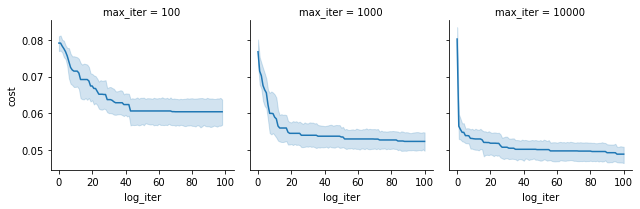

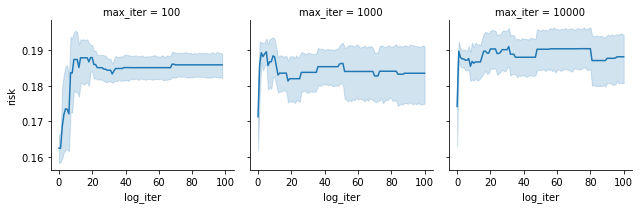

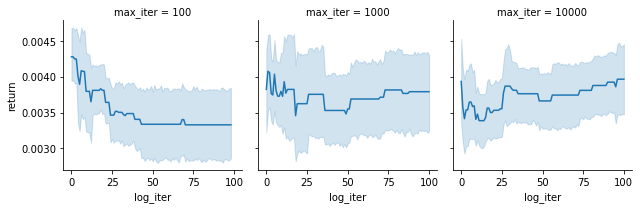

In [11]:
tag = 'tuning_iter'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='max_iter', kind='line', height=3)
sns.relplot(data=data, x='log_iter', y='risk', col='max_iter', kind='line', height=3)
sns.relplot(data=data, x='log_iter', y='return', col='max_iter', kind='line', height=3)

In [12]:
best_data[best_data.tag==tag]
best_data.groupby(['max_iter'], as_index=False)['cost'].mean().sort_values('cost')

,max_iter,cost
0,100,0.004650
1,1000,0.035076
2,10000,0.048515


### Pop Size | Mem Size

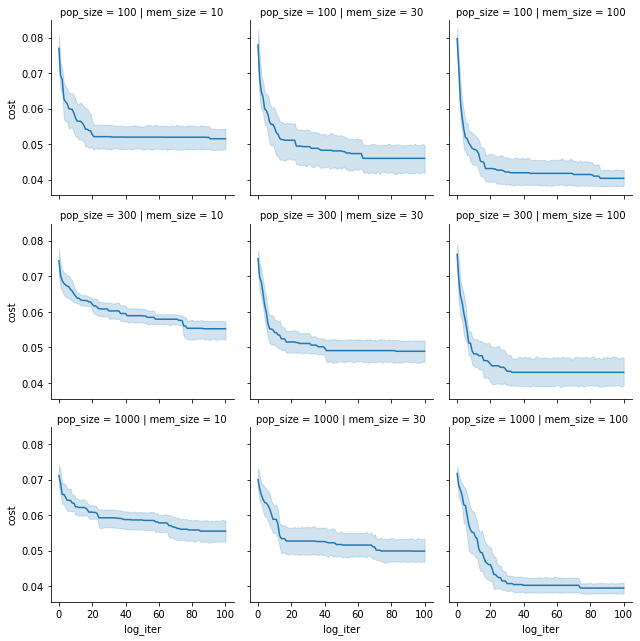

In [13]:
tag = 'tuning_size'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost',row='pop_size', col='mem_size', kind='line', height=3)

In [14]:
best_data[best_data.tag==tag]
best_data.groupby(['pop_size', 'mem_size'], as_index=False)['cost'].mean().sort_values('cost')

,pop_size,mem_size,cost
8,1000,100,0.005546
2,100,100,0.040348
5,300,100,0.042946
1,100,30,0.045980
4,300,30,0.048877
7,1000,30,0.049840
0,100,10,0.053124
3,300,10,0.055225
6,1000,10,0.055468


### Mem Consider

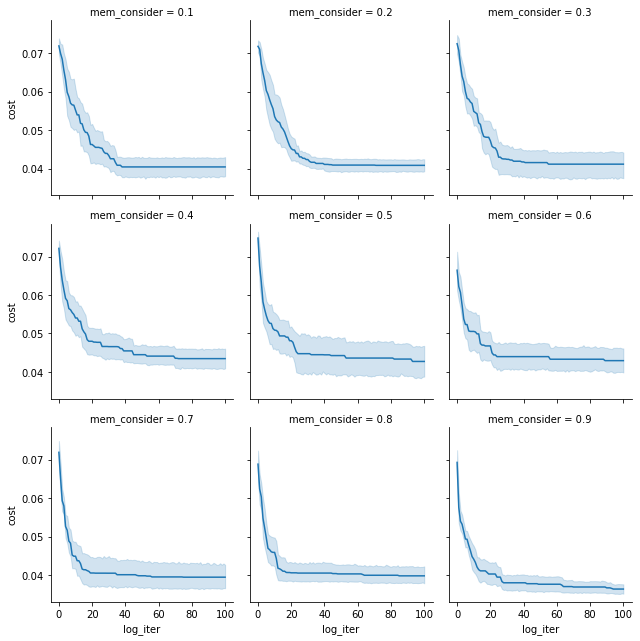

In [15]:
tag = 'tuning_mem_consider'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='mem_consider', col_wrap=3, kind='line', height=3)

In [16]:
best_data[best_data.tag==tag]
best_data.groupby(['mem_consider'], as_index=False)['cost'].mean().sort_values('cost')

,mem_consider,cost
8,0.9,0.005203
6,0.7,0.039475
7,0.8,0.039822
0,0.1,0.040460
1,0.2,0.040869
2,0.3,0.041177
5,0.6,0.042934
3,0.4,0.043458
4,0.5,0.048817


### Par Min | Par Max

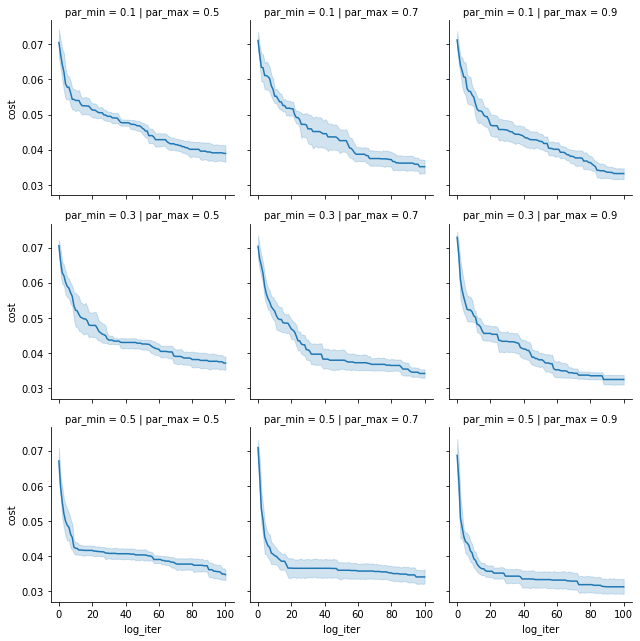

In [17]:
tag = 'tuning_par'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', row='par_min', col='par_max', kind='line', height=3)

In [18]:
best_data[best_data.tag==tag]
best_data.groupby(['par_min', 'par_max'], as_index=False)['cost'].mean().sort_values('cost')

,par_min,par_max,cost
8,0.5,0.9,0.004912
5,0.3,0.9,0.032456
2,0.1,0.9,0.033225
7,0.5,0.7,0.034101
4,0.3,0.7,0.034165
1,0.1,0.7,0.035175
3,0.3,0.5,0.037119
0,0.1,0.5,0.038953
6,0.5,0.5,0.045229


### Bw Min | Bw Max

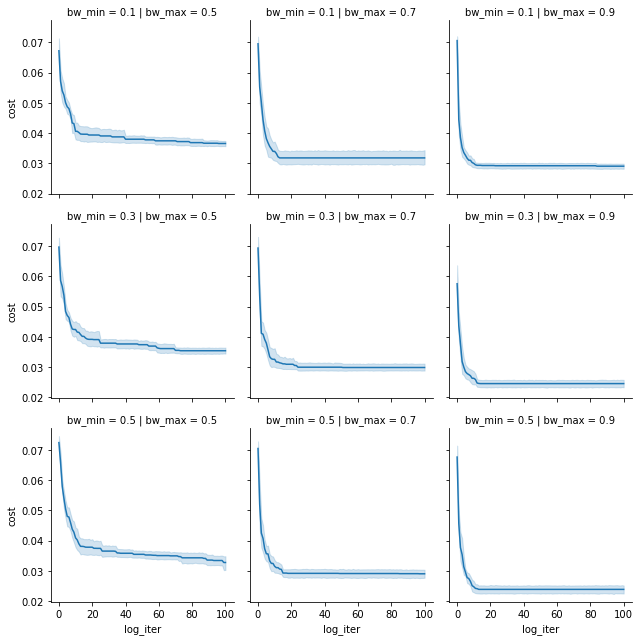

In [19]:
tag = 'tuning_bw'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', row='bw_min', col='bw_max', kind='line', height=3)

In [20]:
best_data[best_data.tag==tag]
best_data.groupby(['bw_min', 'bw_max'], as_index=False)['cost'].mean().sort_values('cost')

,bw_min,bw_max,cost
8,0.5,0.9,0.004654
5,0.3,0.9,0.024557
2,0.1,0.9,0.029051
7,0.5,0.7,0.029059
4,0.3,0.7,0.029878
1,0.1,0.7,0.031788
3,0.3,0.5,0.035420
0,0.1,0.5,0.036556
6,0.5,0.5,0.042105


### Sigma

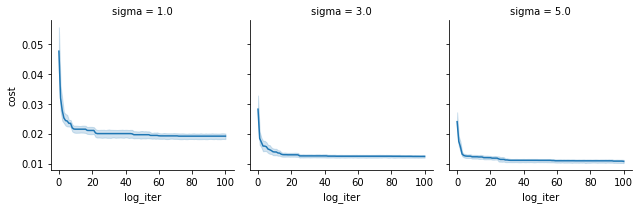

In [21]:
tag = 'tuning_sigma'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='sigma', kind='line', height=3)

In [22]:
best_data[best_data.tag==tag]
best_data.groupby(['sigma'], as_index=False)['cost'].mean().sort_values('cost')

,sigma,cost
3,5.0,0.004608
2,3.0,0.012408
1,1.0,0.019207
0,0.1,0.039647


### Local Search Iterations

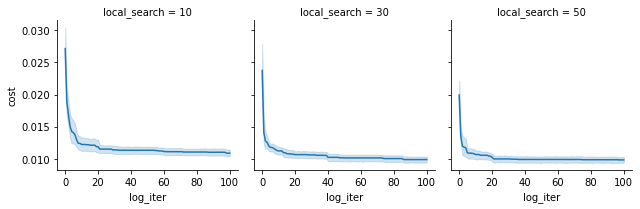

In [23]:
tag = 'tuning_local_search'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='local_search', kind='line', height=3)

In [24]:
best_data[best_data.tag==tag]
best_data.groupby(['local_search'], as_index=False)['cost'].mean().sort_values('cost')

,local_search,cost
0,10,0.004590
3,50,0.009851
2,30,0.009900
1,20,0.037836


## Fronteira de Eficiência

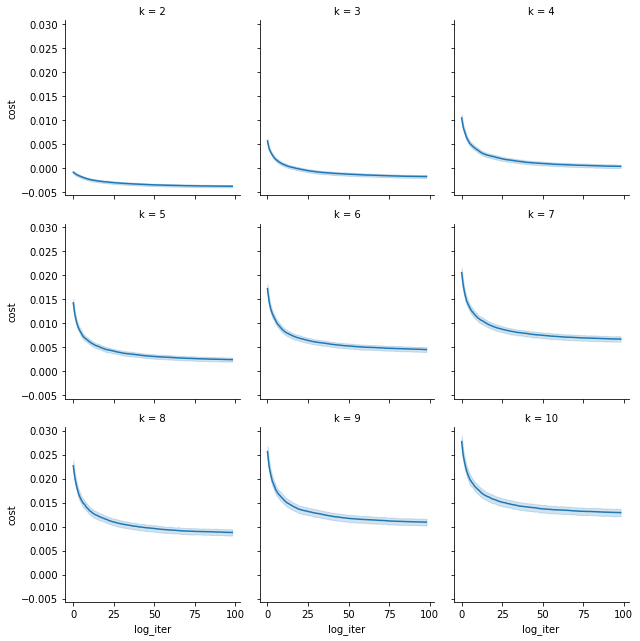

In [25]:
tag = 'problem_solving'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='cost', col='k', col_wrap=3, kind='line', height=3)

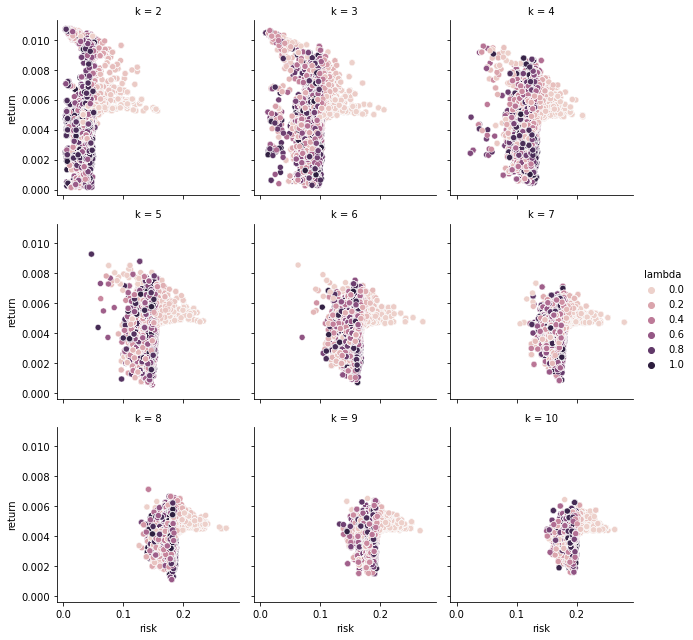

In [26]:
tag = 'problem_solving'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='risk', y='return', col='k', col_wrap=3, hue='lambda', kind='scatter', height=3)

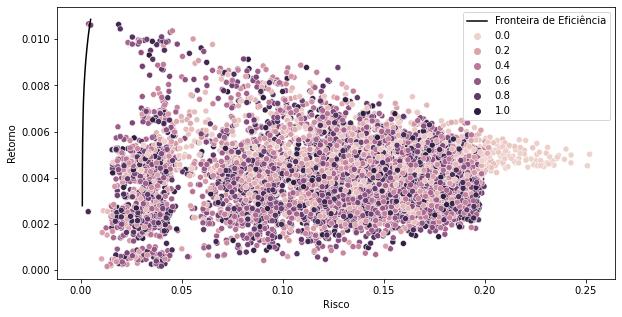

In [27]:
tag = 'problem_solving'
data = best_data[best_data.tag==tag]
plt.figure(figsize=(10,5))
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return, color='k', label='Fronteira de Eficiência')
# plt.scatter(data.obj, data['return'], alpha=0.5, c=data.Q, label='Melhores Resultados')
sns.scatterplot(data=data, x='risk', y='return', hue='lambda')
plt.ylabel("Retorno")
plt.xlabel("Risco")
plt.legend()

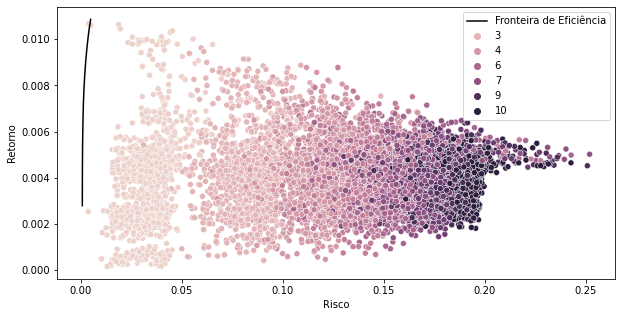

In [28]:
tag = 'problem_solving'
data = best_data[best_data.tag==tag]
plt.figure(figsize=(10,5))
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return, color='k', label='Fronteira de Eficiência')
# plt.scatter(data.obj, data['return'], alpha=0.5, c=data.Q, label='Melhores Resultados')
sns.scatterplot(data=data, x='risk', y='return', hue='k')
plt.ylabel("Retorno")
plt.xlabel("Risco")
plt.legend()

In [29]:
cef = []
tag = 'problem_solving'
for k in tqdm(best_data.k.unique()):
    data = best_data[(best_data.tag==tag) & (best_data.k==k)]
    for i in tqdm(data.index.values):
        cond1 = data[data.index!=i]['return'] > data.loc[i, 'return']
        cond2 = data[data.index!=i]['risk'] <= data.loc[i, 'risk']
        cond3 = data[data.index!=i]['return'] >= data.loc[i, 'return']
        cond4 = data[data.index!=i]['risk'] < data.loc[i, 'risk']
        if (not any(cond1 & cond2)) | (not any(cond3 & cond4)):
            cef.append(i)

100%|██████████| 9/9 [00:24<00:00,  2.75s/it]


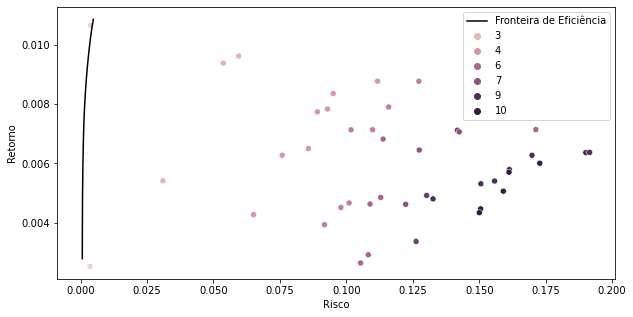

In [30]:
data = all_data.loc[cef]
plt.figure(figsize=(10,5))
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return, color='k', label='Fronteira de Eficiência')
# plt.scatter(data.obj, data['return'], alpha=0.5, c=data.Q, label='Melhores Resultados')
sns.scatterplot(data=data, x='risk', y='return', hue='k')
plt.ylabel("Retorno")
plt.xlabel("Risco")
plt.legend()

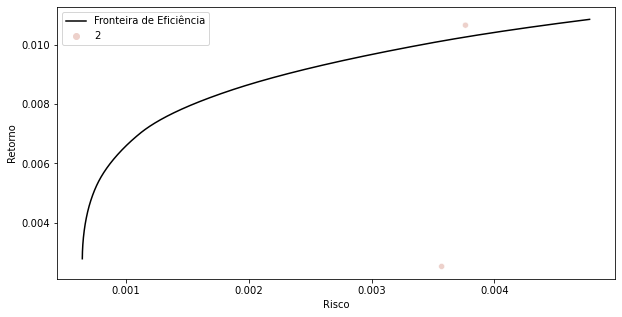

In [31]:
data = all_data.loc[cef]
data = data[data.risk<=0.01]
plt.figure(figsize=(10,5))
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return, color='k', label='Fronteira de Eficiência')
# plt.scatter(data.obj, data['return'], alpha=0.5, c=data.Q, label='Melhores Resultados')
sns.scatterplot(data=data, x='risk', y='return', hue='k')
plt.ylabel("Retorno")
plt.xlabel("Risco")
plt.legend()

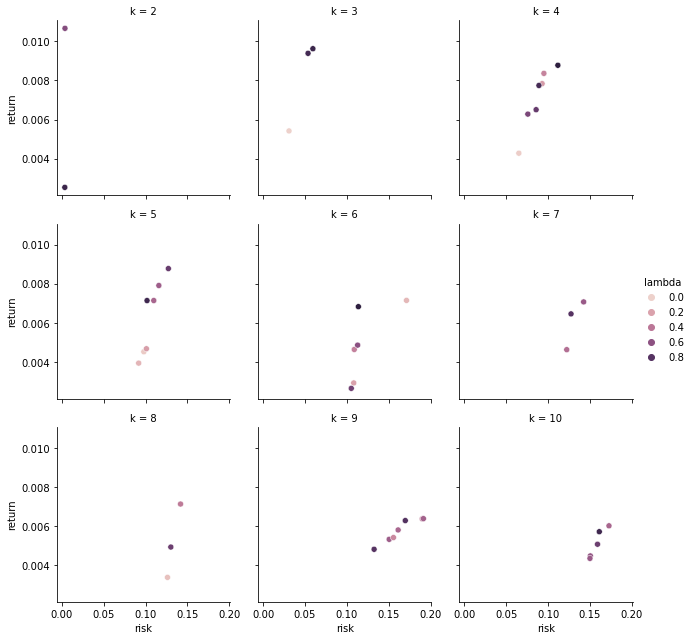

In [32]:
data = all_data.loc[cef]
sns.relplot(data=data, x='risk', y='return', col='k', col_wrap=3, hue='lambda', kind='scatter', height=3)